In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.distances import distance_array

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy
import pandas as pd

from sklearn.cross_decomposition import PLSRegression

In [2]:
# trajectory definition
gro = "../binding_spots_project/gpcr_sampling/b2ar-fst/chol-sdpc/tm36/epoch01/rep01/solu_memb.gro"
xtcs = glob.glob("../binding_spots_project/gpcr_sampling/b2ar-fst/chol-sdpc/tm36/epoch*/rep*/solu_memb_centered.xtc")
space = mda.Universe(gro, xtcs)

In [3]:

def check_centering(universe):
    """checks protein centering in trajectory"""
    protein = universe.select_atoms("protein")
    com_positions = []
    
    for ts in universe.trajectory[0:-1:10]:
        com = protein.center_of_mass()
        com_positions.append(com)
    distances = scipy.spatial.distance.pdist(com_positions)
    biggest = distances.max()
    if biggest > 30:
        print(f"Protein center of mass moved over 30 Å during simulation ({np.round(biggest, 2)} Å). Are you sure the protein is centered?")
    

In [4]:

def calculate_box_size(universe):
    """Calculates the dimensions the density grid should have"""
    atoms = universe.select_atoms("all")
    x_min, x_max = atoms.positions[:,0].min(), atoms.positions[:,0].max()
    y_min, y_max = atoms.positions[:,1].min(), atoms.positions[:,1].max()
    z_min, z_max = atoms.positions[:,2].min(), atoms.positions[:,2].max()
    
    for ts in universe.trajectory:
        
        frame_x_min, frame_x_max = atoms.positions[:,0].min(), atoms.positions[:,0].max()
        frame_y_min, frame_y_max = atoms.positions[:,1].min(), atoms.positions[:,1].max()
        frame_z_min, frame_z_max = atoms.positions[:,2].min(), atoms.positions[:,2].max()
        
        if frame_x_min < x_min: x_min = frame_x_min
        if frame_x_max > x_max: x_max = frame_x_max
        if frame_y_min < y_min: y_min = frame_y_min
        if frame_y_max > y_max: y_max = frame_y_max
        if frame_z_min < z_min: z_min = frame_z_min
        if frame_z_max > z_max: z_max = frame_z_max

    x_dim = x_max - x_min
    y_dim = y_max - y_min
    z_dim = z_max - z_min
    
    return max([x_dim, y_dim, z_dim])



In [5]:

def make_grid(protein_com, dimension, n_grids):
    """Calculates grid points for density grid"""
    x_grids = np.linspace(protein_com[0] - dimension*.5, protein_com[0] + dimension*.5, n_grids)
    y_grids = np.linspace(protein_com[1] - dimension*.5, protein_com[1] + dimension*.5, n_grids)
    z_grids = np.linspace(protein_com[2] - dimension*.5, protein_com[2] + dimension*.5, n_grids)
    
    return x_grids.reshape(-1,1), y_grids.reshape(-1,1), z_grids.reshape(-1,1)
    


In [6]:
def map_to_grid_points(coordinates, x_vals, y_vals, z_vals):
    """Maps every coordinate in coordinates to the closest grid point"""
    x_distances = scipy.spatial.distance.cdist(coordinates[:,0].reshape(-1,1), x_vals)
    y_distances = scipy.spatial.distance.cdist(coordinates[:,1].reshape(-1,1), y_vals)
    z_distances = scipy.spatial.distance.cdist(coordinates[:,2].reshape(-1,1), z_vals)
    x_closest = np.argmin(x_distances, axis=1)
    y_closest = np.argmin(y_distances, axis=1)
    z_closest = np.argmin(z_distances, axis=1)
    
    
    return x_closest, y_closest, z_closest
    
    


In [17]:

def snippet_density_map(universe, selection, n_steps, dimension, n_grids):
    """Calculates densities for 'subtrajectories' of n_steps each"""
    ends = np.arange(0, universe.trajectory.n_frames, n_steps)
    maps = []
    
    print(f"Will calculate {ends.shape[0] - 1} density maps...")
    
    protein = universe.select_atoms("protein")
    atoms = universe.select_atoms(selection)
    
    for i, end in enumerate(ends[:-1]):
        print(f"At snippet {i} / {ends.shape[0] - 1}", end="\r")
        snippet = np.zeros((n_grids, n_grids, n_grids))
        for ts in universe.trajectory[end:ends[i+1]:1]:
            com = protein.center_of_mass()
            x_grids, y_grids, z_grids = make_grid(com, dimension, n_grids)
            x_closest, y_closest, z_closest = map_to_grid_points(atoms.positions, x_grids, y_grids, z_grids)
            snippet[x_closest, y_closest, z_closest] += 1
        snippet = snippet / (atoms.n_atoms * (ends[i + 1] - end))
        maps.append(snippet.reshape(1, n_grids**3))
    
    maps = np.concatenate(maps, axis=0)
    return maps
                

In [18]:
def calculate_tm36(universe):
    resid1 = universe.select_atoms("resid 100 and name CA")
    resid2 = universe.select_atoms("resid 241 and name CA")
    return distance_array(resid1.positions, resid2.positions)[0][0]

In [19]:

def snippet_function_values(universe, function, n_steps):
    """Calculates mean value of function for 'subtrajectories' of n_steps each"""
    ends = np.arange(0, universe.trajectory.n_frames, n_steps)
    function_values = []
    
    print(f"Will calculate {ends.shape[0] - 1} function values...")
    
    for i, end in enumerate(ends[:-1]):
        print(f"At snippet {i} / {ends.shape[0] - 1}", end="\r")
        vals = []
        for ts in universe.trajectory[end:ends[i+1]:1]:
            vals.append(function(universe))
        function_values.append(np.mean(vals))


    return function_values



In [20]:
n_steps = 10
n_grids = 30

X = snippet_density_map(universe=space, selection="name O3", n_steps=n_steps, dimension=150, n_grids=n_grids)
Y = snippet_function_values(space, calculate_tm36, n_steps)



Will calculate 461 density maps...
Will calculate 461 function values...


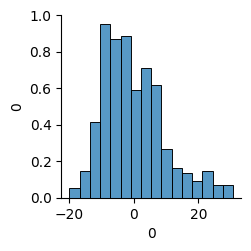

0.6754524131790449


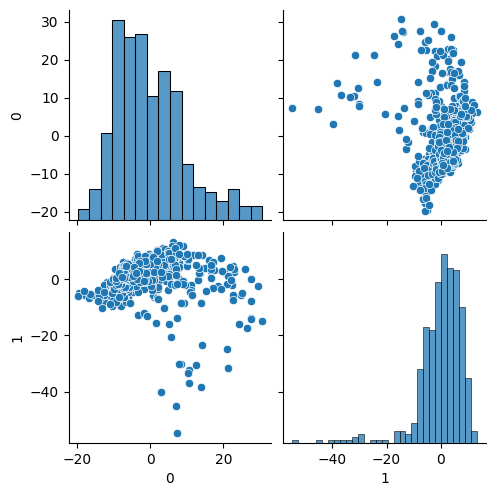

0.8416372263439182


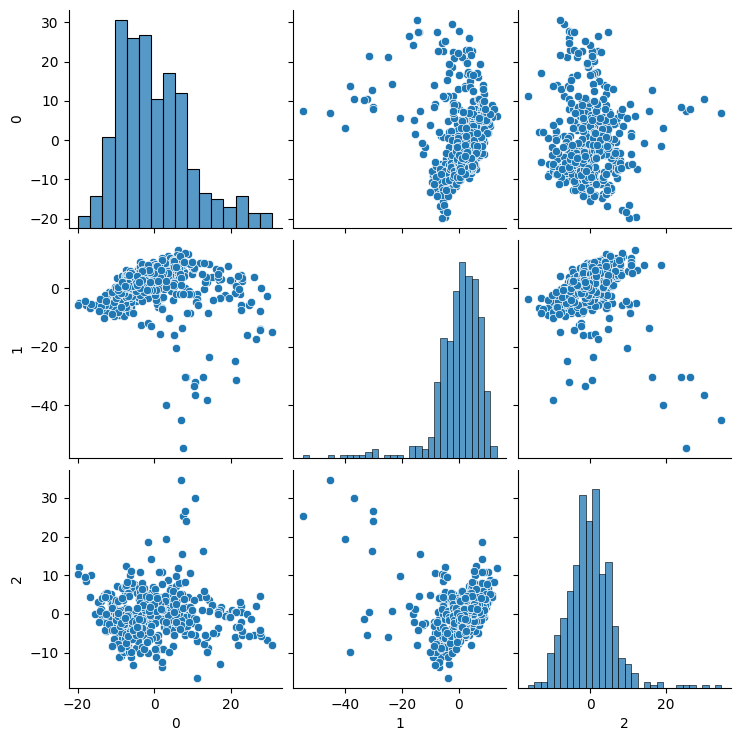

0.9345780524538089


In [22]:

def pls(X, Y):
    
    for n_comp in range(1, 4):
        model = PLSRegression(n_components=n_comp).fit(X, Y)
        sns.pairplot(pd.DataFrame(model.transform(X)))
        plt.show()
        print(model.score(X, Y))

pls(X, Y)

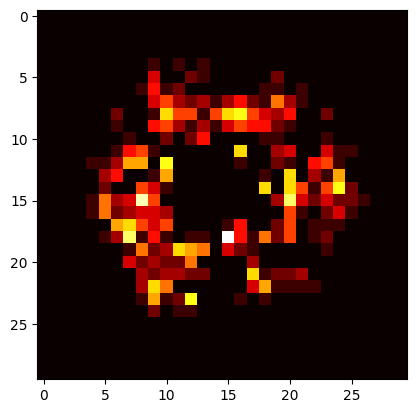

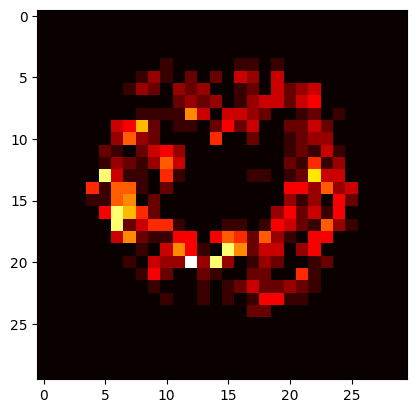

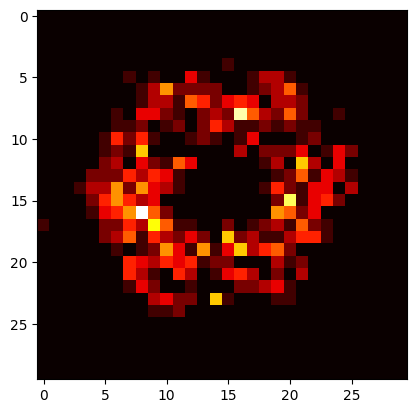

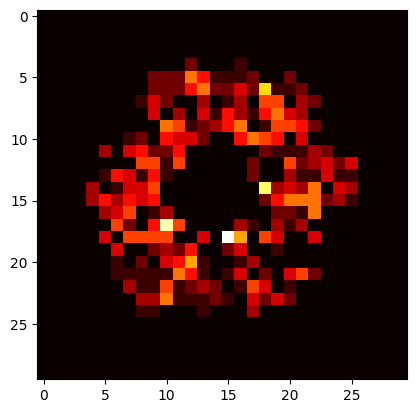

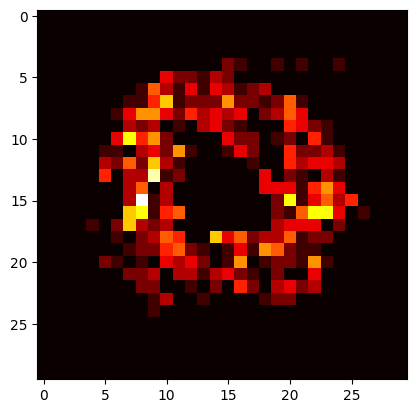

In [24]:

for i in range(5):
    s = np.sum(X[10*i,:].reshape(30, 30, 30), axis=2)
    plt.imshow(s, cmap='hot', interpolation='nearest')
    plt.show()